# Projekt prognoza pogody

## Pytania, pomysły, notatki

Potencjalne problemy:
- Normalnie pogodę prognozuje się [inaczej](https://en.wikipedia.org/wiki/Numerical_weather_prediction), bo pogoda zależy od innych czynników niż tylko przeszłe stany
- Modele lubią zauważać że pogoda zmienia się raczej wolno i przewidywać "jutro będzie tak jak dzisiaj"

Baseline:
- dzisiaj jest tak jak wczoraj
- zawsze średnia
- regresja liniowa
- regresja wielomianowa? (może być już fajna i przydatna do właściwych predykcji)

Lepsze pomysły:
- Metody uczenia zespołowego: Random Forest, AdaBoost, GradientBoost, XGBoost
  - "Małe" modele trenowane na podzbiorach danych z różnych okresów
  - jenen mały model przewiduje temperaturę za godzinę, drugi za dwie, itd, i potem z tego predykcja średniej temperatury danego dnia
  - do tego trzeba zrobić feature engineering: każda krotka dostaje dane o tym co się działo przez ostatni jakiś okres czasu (np temperatura wczoraj, średnia temperatura w tym tygodniu, miesiąc, pora roku) - chcemu obserwować sezonowość + lokalny trend
- lightbgm (on w sumie też robi ensemble) - był na liście 10
- dekompozycja szeregu czasowego: **wtarn**
  - szereg ma trend sezonowy, trend dobowy, i losowy szum wokół tego
  - sprawdzić jak dużo umiemy przewidzieć ponad ten losowy szum
  - jakaś analiza błędów vs sezon -> np bardziej mylimy się wiosną niż latem
- Inne metody do operowania na szeregach czasowych (ich nie było na wykładzie)
  - Wygładzanie wykładnicze (Exponential Smoothing / Holt-Winters) **wtarn**
  - Statystyka: ARIMA / SARIMA **wtarn**
  - Modele addytywne: Facebook Prophet - jest dostępny za freeko, biblioteka `prophet` **młuk**
- Dodać więcej stacji wokół punktu dla którego robimy predykcje. Wtedy można przewidywać na podstawie kierunku wiatru: jak wieje z północy do jutro będzie taka pogoda jak dzisiaj jest na północ od wrocławia.

---


## Dane

In [10]:
%pip install meteostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
# from meteostat import Point, Daily
import meteostat as ms
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Ustawienie ziarna losowości dla powtarzalności wyników
RANDOM_STATE = 42

Współrzędne geograficzne Wrocławia to:

* **Szerokość:** 51.1093° N
* **Długość:** 17.0386° E
* Wysokość n.p.m.: ~120

In [3]:
# Specify location and time range
POINT = ms.Point(51.1093, 17.0386, 120)  # szerokość długość wysokość
#zbyt mało da nam mało pomiarów, zbyt dużo nie pozwoli pobrać danych godzinnych
START = date(2023, 1, 1) # TODO ustawić więcej, nie chciało mi się czekać aż się pobierze
END = date.today()

# Get nearby weather stations
stations = ms.stations.nearby(POINT, limit=4)
stations


,name,country,region,latitude,longitude,elevation,timezone,distance
id,,,,,,,,
12424,Wroclaw Copernicus Airport,PL,DO,51.1,16.8833,120,Europe/Warsaw,10892.1


In [4]:
WROCLAW_STATION_ID=12424
df_daily = ms.daily(ms.Station(id=WROCLAW_STATION_ID), START, END).fetch()
df_hourly = ms.hourly(ms.Station(id=WROCLAW_STATION_ID), START, END).fetch()


Znaczenie kolumn w tabeli Meteostat "daily":

* **temp**: Średnia temperatura dobowa (°C)
* **tmin**: Minimalna temperatura (°C)
* **tmax**: Maksymalna temperatura (°C)
* **rhum**: Wilgotność względna (%)
* **prcp**: Dobowa suma opadów (mm)
* **wspd**: Średnia prędkość wiatru (km/h)
* **wpgt**: Najsilniejszy poryw wiatru (km/h)
* **pres**: Ciśnienie atmosferyczne na poziomie morza (hPa)
* **cldc**: Średnie zachmurzenie (%)

In [5]:
df_daily.head()

,temp,tmin,tmax,rhum,prcp,snwd,wspd,wpgt,pres,tsun,cldc
time,,,,,,,,,,,
2023-01-01,14.8,11.4,17.9,60,0.0,<NA>,18.6,42.6,1019.2,<NA>,7
2023-01-02,11.4,8.8,14.7,73,0.0,<NA>,12.8,31.5,1019.4,<NA>,7
2023-01-03,6.9,-0.5,11.0,85,0.0,<NA>,10.0,29.6,1027.6,<NA>,6
2023-01-04,4.7,-1.3,9.7,84,1.9,<NA>,17.9,48.2,1021.6,<NA>,6
2023-01-05,9.1,5.8,11.6,76,4.3,<NA>,26.1,59.3,1012.1,<NA>,7


Znaczenie kolumn w danych godzinowych Meteostat:

| Kolumna | Znaczenie | Jednostka |
| --- | --- | --- |
| **temp** | Temperatura powietrza | °C |
| **rhum** | Wilgotność względna | % |
| **prcp** | Opady (godzinowa suma) | mm |
| **snwd** | Głębokość pokrywy śnieżnej | mm |
| **wdir** | Kierunek wiatru | stopnie (0-360°) |
| **wspd** | Średnia prędkość wiatru | km/h |
| **wpgt** | Szczytowy poryw wiatru | km/h |
| **pres** | Ciśnienie atmosferyczne (na poz. morza) | hPa |
| **tsun** | Czas nasłonecznienia w danej godzinie | minuty |
| **cldc** | Zachmurzenie ogólne | oktawy (0-8) lub % |
| **coco** | Kod warunków pogodowych (Condition Code) | (numeryczny) |

`coco`: To kody liczbowe (np. 1 = Clear, 3 = Cloudy, 14 = Thunderstorm).

In [6]:
df_hourly.head()

,temp,rhum,prcp,snwd,wdir,wspd,wpgt,pres,tsun,cldc,coco
time,,,,,,,,,,,
2023-01-01 00:00:00,13.9,69,0.0,<NA>,240,14.4,37.0,1016.4,<NA>,7,4
2023-01-01 01:00:00,14.4,65,0.0,<NA>,240,14.4,35.2,1016.7,<NA>,7,3
2023-01-01 02:00:00,16.0,55,0.0,<NA>,240,25.2,33.3,1016.9,<NA>,7,3
2023-01-01 03:00:00,16.0,55,0.0,<NA>,230,21.6,33.3,1017.1,<NA>,7,3
2023-01-01 04:00:00,15.9,56,0.0,<NA>,240,25.2,33.3,1017.4,<NA>,7,3


In [7]:
print(df_hourly.isna().mean() * 100)
print(df_daily.isna().mean() * 100)

temp      0.000000
rhum      0.000000
prcp      1.820571
snwd     99.692192
wdir      0.000000
wspd      0.000000
wpgt      0.000000
pres      0.000000
tsun    100.000000
cldc      0.007508
coco      0.000000
dtype: float64
temp      0.000000
tmin      0.000000
tmax      0.000000
rhum      0.000000
prcp      1.531532
snwd     97.657658
wspd      0.000000
wpgt      0.000000
pres      0.000000
tsun    100.000000
cldc      0.000000
dtype: float64


## Szybki teścik: regresja liniowa + random forest

**To jest na danych dziennych, ale pewnie docelowe chcemy używać tych godzinowych**

In [ ]:
df = df_daily.copy()

df['Target'] = df['temp'].shift(1)

# Cechy: Co wiedzieliśmy WCZORAJ i wcześniej?
df['T_dzisiaj'] = df['temp'].shift(-1)
df['T_wczoraj'] = df['temp'].shift(-2)
df['T_3dnitemu'] = df['temp'].shift(-3)
df['temp_change'] = df['temp'].diff()

# Średnia krocząca z 3 dni
df['Rolling_Mean_7'] = df['temp'].rolling(window=7).mean().shift(-7)

# Dodajemy informacje o sezonie
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear

In [ ]:
# Usuwamy kolumny z brakami
df = df.drop(columns=['snwd', 'tsun'])
df = df.dropna()

In [ ]:
# Definiujemy cechy (X) i cel (y)
features = ['temp_change','T_wczoraj', 'T_dzisiaj', 'T_3dnitemu', 'Rolling_Mean_7', 'Month', 'prcp', 'wspd', 'pres', 'rhum']
target = 'Target'

X = df[features]
y = df[target]

# Podział chronologiczny (np. ostatni rok to test)
test_days = 365
X_train, X_test = X.iloc[:-test_days], X.iloc[-test_days:]
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]

print(f"Trening: {X_train.shape}, Test: {X_test.shape}")

Trening: (719, 10), Test: (365, 10)


In [ ]:
# 1. Baseline: Regresja Liniowa
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# 2. Model Główny: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

--- Regresja Liniowa ---
MAE (średni błąd bezwzględny): 1.64 °C
RMSE (błąd średniokwadratowy): 2.03 °C
--- Random Forest ---
MAE (średni błąd bezwzględny): 1.76 °C
RMSE (błąd średniokwadratowy): 2.23 °C


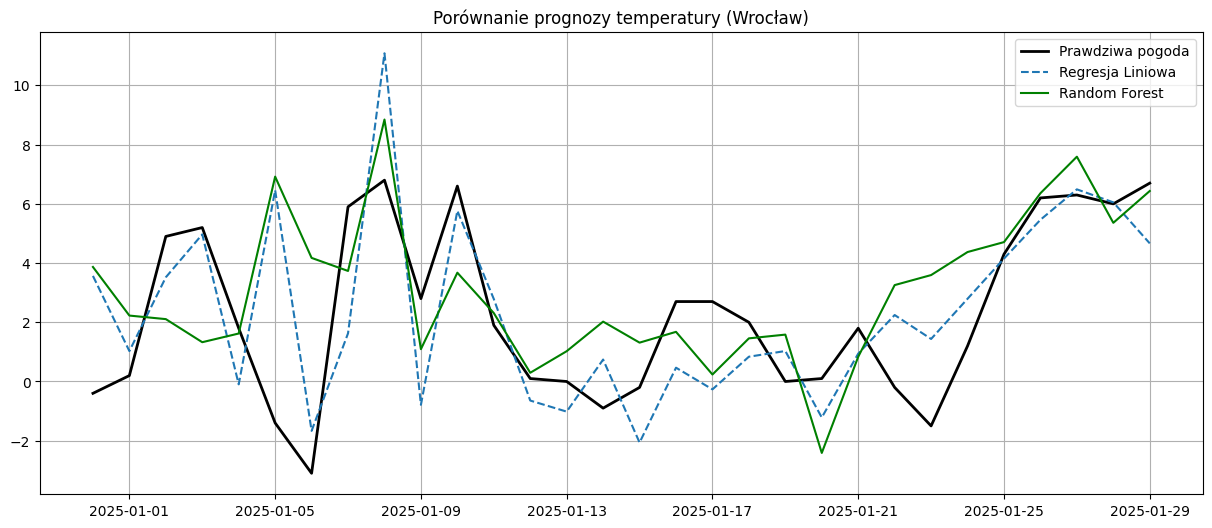

In [ ]:
# Funkcja do oceny
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} ---")
    print(f"MAE (średni błąd bezwzględny): {mae:.2f} °C")
    print(f"RMSE (błąd średniokwadratowy): {rmse:.2f} °C")

evaluate(y_test, lr_preds, "Regresja Liniowa")
evaluate(y_test, rf_preds, "Random Forest")

# Wizualizacja (tylko pierwszy miesiąc testowy dla czytelności)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:30], y_test.values[:30], label='Prawdziwa pogoda', color='black', linewidth=2)
plt.plot(y_test.index[:30], lr_preds[:30], label='Regresja Liniowa', linestyle='--')
plt.plot(y_test.index[:30], rf_preds[:30], label='Random Forest', color='green')
plt.title("Porównanie prognozy temperatury (Wrocław)")
plt.legend()
plt.grid(True)
plt.show()

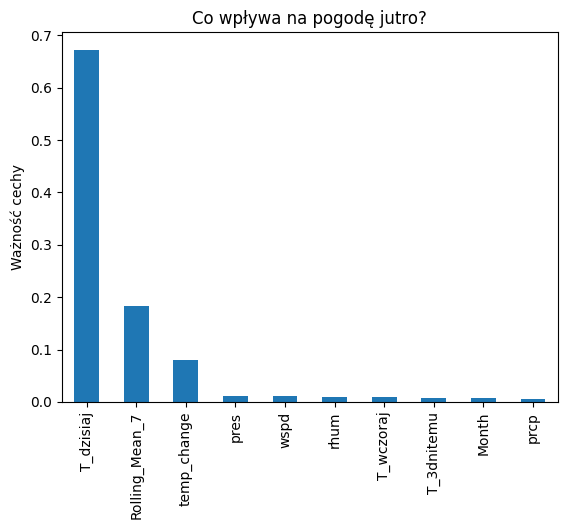

In [ ]:

importances = rf_model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

forest_importances.plot.bar()
plt.title("Co wpływa na pogodę jutro?")
plt.ylabel("Ważność cechy")
plt.show()

## Metody ensemble

--- XGBoost ---
MAE (średni błąd bezwzględny): 1.83 °C
RMSE (błąd średniokwadratowy): 2.32 °C


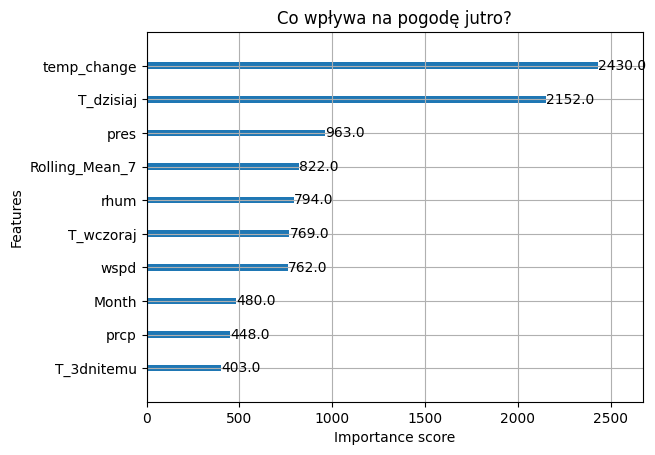

In [ ]:
import xgboost as xgb

# Model XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Wydzielamy ostatnie 10% treningu jako walidację
split_val = int(len(X_train) * 0.9)
X_tr_sub, X_val = X_train.iloc[:split_val], X_train.iloc[split_val:]
y_tr_sub, y_val = y_train.iloc[:split_val], y_train.iloc[split_val:]

xgb_model.fit(
    X_tr_sub, y_tr_sub,
    eval_set=[(X_tr_sub, y_tr_sub), (X_val, y_val)],
    verbose=None
)

# Predykcja
xgb_preds = xgb_model.predict(X_test)

evaluate(y_test, xgb_preds, "XGBoost")

# Wykres ważności cech dla XGBoost
xgb.plot_importance(xgb_model, title="Co wpływa na pogodę jutro?")
plt.show()

### Implementacja + ewaluacja któregoś z pomysłów (TODO)

np to:

jenen mały model przewiduje temperaturę za godzinę, drugi za dwie, itd, i potem z tego predykcja średniej temperatury danego dnia


### Implementacja + ewaluacja innego pomysłu (TODO)

--- Facebook Prophet ---
MAE (średni błąd bezwzględny): 2.75 °C
RMSE (błąd średniokwadratowy): 3.56 °C


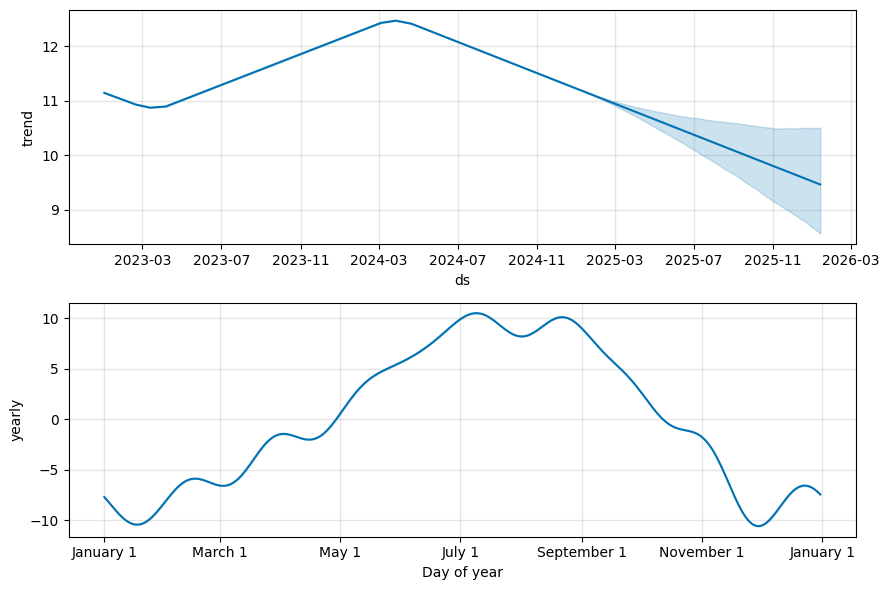

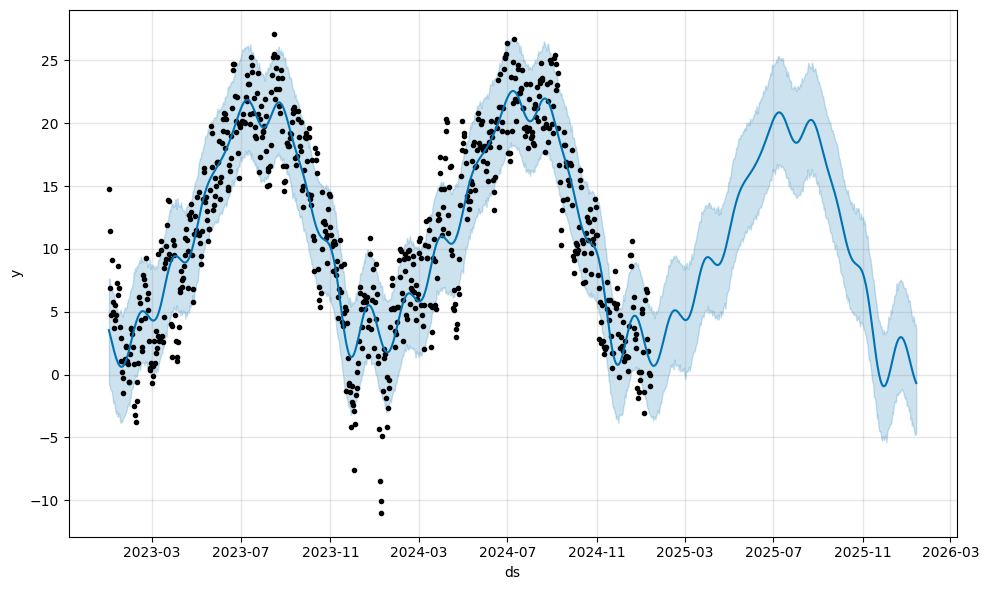

In [ ]:
from prophet import Prophet

# Prophet wymaga specyficznych nazw kolumn: 'ds' (data) i 'y' (wartość)
df_prophet = df_daily.reset_index()[['time', 'temp']].rename(columns={'time': 'ds', 'temp': 'y'})

train_prophet = df_prophet.iloc[:-test_days]
test_prophet = df_prophet.iloc[-test_days:]

# Inicjalizacja i trening
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_prophet)

# Predykcja
# Tworzymy dataframe z datami przyszłymi (okres testowy)
future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)

# Wyciągamy predykcje dla zbioru testowego
forecast_test = forecast.iloc[-test_days:]['yhat'].values

evaluate(test_prophet['y'], forecast_test, "Facebook Prophet")

# Wizualizacja komponentów
fig = m.plot_components(forecast)
plt.show()

# Wizualizacja predykcji
fig2 = m.plot(forecast)
plt.show()

### Feature engineering na prognozie godzinnej

In [8]:
df_eng = df_hourly.copy()

df_eng['hour'] = df_eng.index.hour

# Time of Day bins: Night (0-5), Morning (6-11), Day (12-17), Evening (18-23)
df_eng['time_of_day'] = pd.cut(
    df_eng['hour'],
    bins=[-1, 5, 11, 17, 24],
    labels=['Night', 'Morning', 'Day', 'Evening'],
    ordered=False
)

# Temperature Lags
# Previous hour, 2 hours ago, and same time yesterday
df_eng['temp_lag_1h'] = df_eng['temp'].shift(1)
df_eng['temp_lag_2h'] = df_eng['temp'].shift(2)
df_eng['temp_lag_24h'] = df_eng['temp'].shift(24)

# Rolling Statistics (Hourly Source)
# Rolling mean and standard deviation for 3 hours
df_eng['temp_roll_mean_3h'] = df_eng['temp'].rolling(window=3).mean()
df_eng['temp_roll_std_3h'] = df_eng['temp'].rolling(window=3).std()

# Rolling mean and standard deviation for 6 hours
df_eng['temp_roll_mean_6h'] = df_eng['temp'].rolling(window=6).mean()
df_eng['temp_roll_std_6h'] = df_eng['temp'].rolling(window=6).std()

# Daily Average (Merged from df_daily)
df_eng['date_key'] = df_eng.index.normalize()
daily_features = df_daily.copy()[['temp']].rename(columns={'temp': 'temp_daily_avg'})

# Merge hourly data with daily averages
df_eng = df_eng.merge(
    daily_features,
    left_on='date_key',
    right_index=True,
    how='left'
)
df_eng = df_eng.drop(columns=['date_key'])

# Display results
df_eng.head(10)

,temp,rhum,prcp,snwd,wdir,wspd,wpgt,pres,tsun,cldc,...,hour,time_of_day,temp_lag_1h,temp_lag_2h,temp_lag_24h,temp_roll_mean_3h,temp_roll_std_3h,temp_roll_mean_6h,temp_roll_std_6h,temp_daily_avg
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,13.9,69,0.0,<NA>,240,14.4,37.0,1016.4,<NA>,7,...,0,Night,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,14.8
2023-01-01 01:00:00,14.4,65,0.0,<NA>,240,14.4,35.2,1016.7,<NA>,7,...,1,Night,13.9,<NA>,<NA>,NaN,NaN,NaN,NaN,14.8
2023-01-01 02:00:00,16.0,55,0.0,<NA>,240,25.2,33.3,1016.9,<NA>,7,...,2,Night,14.4,13.9,<NA>,14.766667,1.096966,NaN,NaN,14.8
2023-01-01 03:00:00,16.0,55,0.0,<NA>,230,21.6,33.3,1017.1,<NA>,7,...,3,Night,16.0,14.4,<NA>,15.466667,0.923760,NaN,NaN,14.8
2023-01-01 04:00:00,15.9,56,0.0,<NA>,240,25.2,33.3,1017.4,<NA>,7,...,4,Night,16.0,16.0,<NA>,15.966667,0.057735,NaN,NaN,14.8
2023-01-01 05:00:00,14.8,59,0.0,<NA>,220,18.0,31.5,1017.9,<NA>,7,...,5,Night,15.9,16.0,<NA>,15.566667,0.665833,15.166667,0.922316,14.8
2023-01-01 06:00:00,15.0,58,0.0,<NA>,220,25.2,29.6,1018.2,<NA>,7,...,6,Morning,14.8,15.9,<NA>,15.233333,0.585947,15.350000,0.703562,14.8
2023-01-01 07:00:00,15.1,57,0.0,<NA>,230,25.2,29.6,1018.3,<NA>,7,...,7,Morning,15.0,14.8,<NA>,14.966667,0.152753,15.466667,0.557375,14.8
2023-01-01 08:00:00,15.4,57,0.0,<NA>,230,25.2,31.5,1018.8,<NA>,7,...,8,Morning,15.1,15.0,<NA>,15.166667,0.208167,15.366667,0.492612,14.8


In [11]:
# predict temperature 24 hours into the future
df_ml = df_eng.copy()
df_ml['target_24h'] = df_ml['temp'].shift(-24)

# Drop rows where target is NaN (the last 24 hours of data cannot be used for training yet)
df_model = df_ml.dropna(subset=['target_24h'])

# features
features = [
    'hour', 'temp', 'temp_lag_1h', 'temp_lag_2h', 'temp_lag_24h',
    'temp_roll_mean_3h', 'temp_roll_std_3h', 'temp_daily_avg'
]
target = 'target_24h'

X = df_model[features]
y = df_model[target]

# Time Series Split (Last 7 days as test set)
test_hours = 24 * 7
X_train, X_test = X.iloc[:-test_hours], X.iloc[-test_hours:]
y_train, y_test = y.iloc[:-test_hours], y.iloc[-test_hours:]

# Train Model
model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f} °C")

MAE: 3.17 °C


In [14]:
# "FORECAST FOR TOMORROW"
# We take the last 24 rows from the original dataset (which have NaN targets)
last_day_data = df_ml.iloc[-24:][features]

forecast_tomorrow = model.predict(last_day_data)

import pandas as pd
future_dates = pd.date_range(
    start=df_ml.index[-1] + pd.Timedelta(hours=1),
    periods=24,
    freq='h'
)

forecast_df = pd.DataFrame({
    'datetime': future_dates,
    'predicted_temp': forecast_tomorrow
}).set_index('datetime')

print("\nForecast for the next 24 hours:")
print(forecast_df.head(24))


Forecast for the next 24 hours:
                     predicted_temp
datetime                           
2026-01-15 00:00:00       -1.624017
2026-01-15 01:00:00       -1.695318
2026-01-15 02:00:00       -1.830276
2026-01-15 03:00:00       -2.347393
2026-01-15 04:00:00       -1.919154
2026-01-15 05:00:00       -1.934391
2026-01-15 06:00:00       -2.810479
2026-01-15 07:00:00       -2.388055
2026-01-15 08:00:00       -0.783082
2026-01-15 09:00:00        0.737682
2026-01-15 10:00:00        4.333147
2026-01-15 11:00:00        4.196772
2026-01-15 12:00:00        3.860964
2026-01-15 13:00:00        3.546576
2026-01-15 14:00:00        3.168772
2026-01-15 15:00:00        3.724067
2026-01-15 16:00:00        3.259902
2026-01-15 17:00:00        2.797458
2026-01-15 18:00:00        2.540966
2026-01-15 19:00:00        2.983704
2026-01-15 20:00:00        2.290410
2026-01-15 21:00:00        3.215734
2026-01-15 22:00:00        3.740054
2026-01-15 23:00:00        2.907297


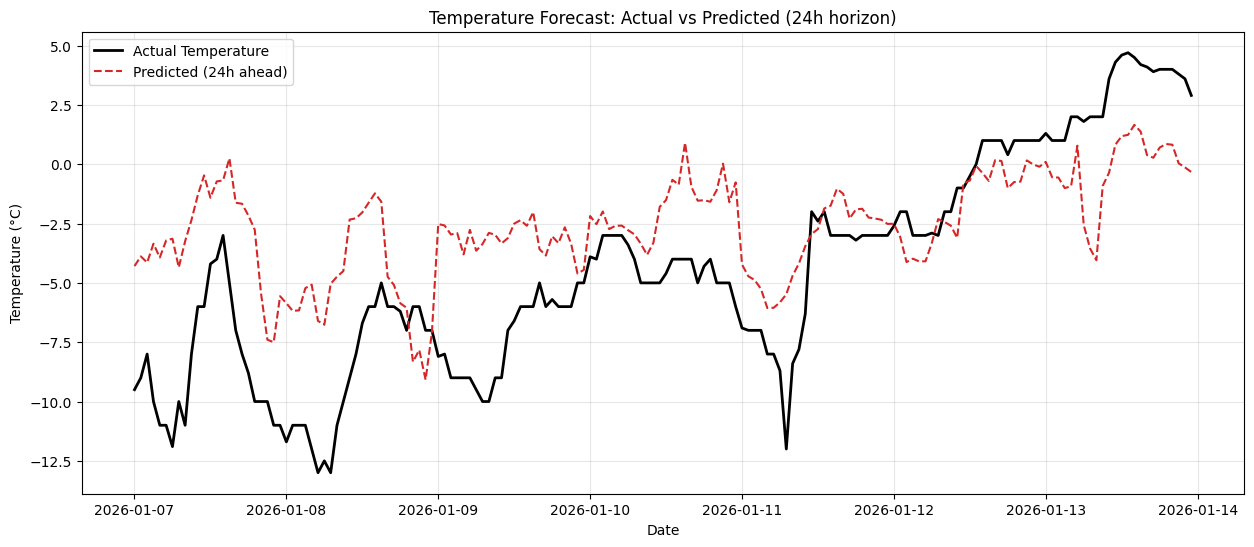

In [15]:
# Plotting the comparison
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual Temperature', color='black', linewidth=2)
plt.plot(y_test.index, preds, label='Predicted (24h ahead)', color='#d62728', linestyle='--')

plt.title('Temperature Forecast: Actual vs Predicted (24h horizon)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()